Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/gnn_workshop_riiaa/blob/master/Prediccion de Nodos con Arxiv MAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
!wget https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
github_repo = 'https://github.com/beangoben/gnn_workshop_riiaa'
import colab_utils
colab_utils.clone_repo(github_repo)

--2021-08-25 14:53:00--  https://raw.githubusercontent.com/beangoben/gnn_workshop_riiaa/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2021-08-25 14:53:00 (83.0 MB/s) - ‘colab_utils.py’ saved [7173/7173]

CMD: git clone --recursive https://github.com/beangoben/gnn_workshop_riiaa


Install stuff

In [2]:
if colab_utils.is_running_colab():
    colab_utils.pip_install(['umap-learn', 'dm-sonnet', 'graph_nets', 'ogb', 'ml-collections'])

CMD: pip install  umap-learn
Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=ea0ab578681963c4e433c32971d5808ff9c44017e8baccf6b459297651f7311b
Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=e57c24a58e2e118d315f5448c571add2a47a44c59d3f4c326b576b51103feb76
Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent
CMD: pip install  dm-sonnet
CMD: pip install  graph_nets
Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91856 sha256=c1ecad84fb9e0f077b69735f33de3ade8d79b48d6edfa07a9dec91fe5a7051d2
Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
CMD: pip install  ogb
Created wheel for littleutils: file

# Import modules


In [4]:
import os
from collections import OrderedDict, defaultdict

import tqdm.auto as tqdm
import colab_utils 
import ml_collections

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import networkx as nx

import sklearn
import umap
import tensorflow as tf
import sonnet as snt
import graph_nets as gn
import ogb

colab_utils.print_module_versions([umap, tf, snt, nx, ogb])
print(f'Tiene GPU? {tf.config.list_physical_devices("gpu")}')
colab_utils.matplotlib_settings()

umap      : 0.5.1
tensorflow: 2.6.0
sonnet    : 2.0.0
networkx  : 2.6.2
ogb       : 1.3.1
Tiene GPU? []


## Bajar dataset (arxiv)

In [5]:
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name = 'ogbn-arxiv')
dataset

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:40<00:00,  2.01it/s]


Extracting dataset/arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 9642.08it/s]

Saving...


NodePropPredDataset(1)

In [9]:
dataset.meta_info

num tasks                                                                1
num classes                                                             40
eval metric                                                            acc
task type                                        multiclass classification
download_name                                                        arxiv
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/nodeproppred...
add_inverse_edge                                                     False
has_node_attr                                                         True
has_edge_attr                                                        False
split                                                                 time
additional node files                                            node_year
additional edge files                                                 None
is hetero                

In [162]:
!wget https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/titleabs.tsv.gz -O titleabs.tsv.gz

--2021-08-25 16:06:59--  https://snap.stanford.edu/ogb/data/misc/ogbn_arxiv/titleabs.tsv.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70213527 (67M) [application/x-gzip]
Saving to: ‘titleabs.tsv.gz’

titleabs.tsv.gz     100%[===================>]  66.96M  2.87MB/s    in 32s     

2021-08-25 16:07:32 (2.07 MB/s) - ‘titleabs.tsv.gz’ saved [70213527/70213527]



In [181]:
paper_df = pd.read_csv('titleabs.tsv.gz', sep='\t', compression="gzip", names=['paper id', 'title', 'abstract'],)
paper_df = paper_df.drop(0,axis=0).dropna()
paper_df['paper id'] = paper_df['paper id'].astype(int)
paper_df.set_index('paper id', drop=True, inplace=True)
paper_df

,title,abstract
paper id,,
549074,a novel methodology for thermal analysis a 3 d...,The semiconductor industry is reaching a fasci...
630234,spreadsheets on the move an evaluation of mobi...,The power of mobile devices has increased dram...
803423,multi view metric learning for multi view vide...,Traditional methods on video summarization are...
1102481,big data analytics in future internet of things,Current research on Internet of Things (IoT) m...
1532644,machine learner for automated reasoning 0 4 an...,Machine Learner for Automated Reasoning (MaLAR...
...,...,...
3012554562,federated visual classification with real worl...,Federated Learning enables visual models to be...
3012555423,kernel quantization for efficient network comp...,This paper presents a novel network compressio...
3012556759,generating electronic health records with mult...,Sharing electronic health records (EHRs) on a ...


## Data-wrangling

In [10]:
def get_topk_labels(dataset, k=10):
    """Conserguir las categorias mas pobladas."""
    unique, counts = np.unique(dataset.labels.ravel(), return_counts=True)
    sorted_labels = np.argsort(counts)[::-1]
    
    adf = pd.read_csv(os.path.join('dataset/ogbn_arxiv/mapping', 'labelidx2arxivcategeory.csv.gz'), compression="gzip")
    label_to_category = dict(zip(adf['label idx'], adf['arxiv category']))
    top_labels = sorted_labels[:k]
    return top_labels, [label_to_category[i] for i in top_labels]

top_labels, categories = get_topk_labels(dataset, 10)
N_LABELS = len(top_labels)
top_labels, categories

(array([16, 24, 28, 30, 10, 34,  8,  4,  5,  2]),
 ['arxiv cs cv',
  'arxiv cs lg',
  'arxiv cs it',
  'arxiv cs cl',
  'arxiv cs ai',
  'arxiv cs ds',
  'arxiv cs ni',
  'arxiv cs cr',
  'arxiv cs dc',
  'arxiv cs lo'])

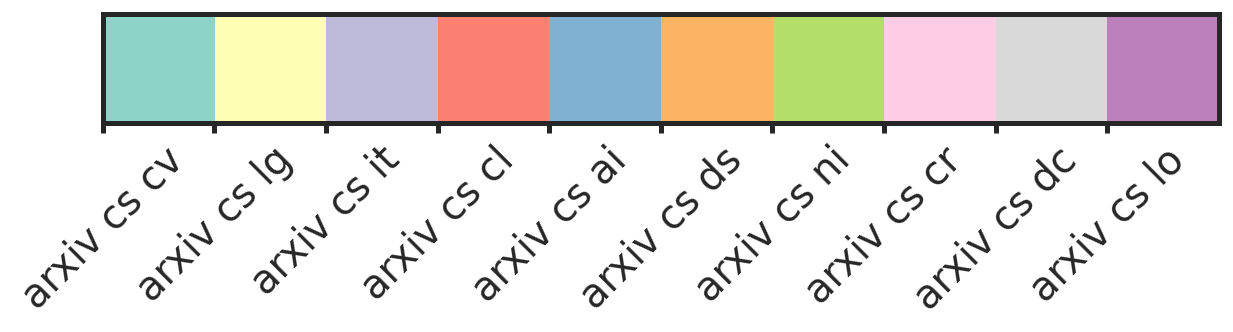

In [11]:
def labels_to_nodecolors(labels, k=10):
    """Convierte etqiuetas a colores."""
    cols = sns.color_palette("Set3", k)
    return [cols[int(l)] for l in labels.ravel()]

def plot_color_legend(k=10):
    cols = sns.color_palette("Set3", k)
    sns.palplot(cols)
    plt.xticks(np.arange(N_LABELS)-0.5, categories, rotation=45)
    plt.show()
    
plot_color_legend()

## Construir train-test split

In [12]:
def make_arxiv_subset(dataset, split, label_subset=None, large_cc=True):
    """Get a split of the arxiv dataset"""

    n_edges = dataset.graph['edge_index'].shape[1]
    n_nodes = dataset.graph['node_feat'].shape[0]
    data_dict = {
        'nodes':dataset.graph['node_feat'].astype(np.float32),
        'edges':np.zeros((n_edges, 1),dtype=np.float32),
        'senders':dataset.graph['edge_index'][0],
        'receivers':dataset.graph['edge_index'][1],
        'globals':np.zeros(1,dtype=np.float32),
    }
    y = dataset.labels
    # Get paper ids
    adf = pd.read_csv(os.path.join('dataset/ogbn_arxiv/mapping', 'nodeidx2paperid.csv.gz'), compression="gzip")
    paperids = adf['paper id'].values
    # Convert to networkx
    g = gn.utils_np.data_dict_to_networkx(data_dict)

    # Subset by indices
    indices = dataset.get_idx_split()[split]
    y = y[indices]
    paperids = paperids[indices]
    g = g.subgraph(indices)
    g = nx.relabel.convert_node_labels_to_integers(g)
    print(len(indices), y.shape, len(g.nodes))

    # Subset by labels
    if label_subset is not None:
        is_top = np.isin(y.ravel(), top_labels)
        top_indices = np.arange(len(g.nodes))[is_top]
        y = y[top_indices]
        g = g.subgraph(top_indices)
        g = nx.relabel.convert_node_labels_to_integers(g)
        paperids = paperids[top_indices]

    # Get largest component.
    if large_cc:
        gcc = list(sorted(nx.connected_components(g.to_undirected()), key=len, reverse=True)[0])
        print(len(gcc), np.max(gcc), len(y))
        g = g.subgraph(gcc)
        g = nx.relabel.convert_node_labels_to_integers(g)
        y = y[gcc]
        paperids = paperids[gcc]
    
    # relabel labels to 0 to n-labels
    new_labels = {j:i for i,j in enumerate(label_subset)}
    y = np.array([new_labels[i] for i in y.ravel()]).reshape(-1,1)
    return g, y, paperids

g_train, y_train, paperids_train = make_arxiv_subset(dataset, 'train', top_labels, True)
g_valid, y_valid, paperids_valid = make_arxiv_subset(dataset, 'valid', top_labels, False)

print(len(g_train.nodes), len(y_train), len(paperids_train))
print(len(g_valid.nodes), len(y_valid), len(paperids_valid))

90941 (90941, 1) 90941
55428 61669 61670
29799 (29799, 1) 29799
55428 55428 55428
22021 22021 22021


## Adentro de los datos

In [13]:
data_dict = gn.utils_np.networkx_to_data_dict(g_train)
data_dict

{'edges': array([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=float32),
 'globals': array([0.], dtype=float32),
 'n_edge': 272227,
 'n_node': 55428,
 'nodes': array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
         -0.140059],
        [-0.1245  , -0.070665, -0.325202, ...,  0.068524, -0.372111,
         -0.301036],
        [-0.080242, -0.023328, -0.183787, ...,  0.109919,  0.117589,
         -0.139883],
        ...,
        [-0.174095,  0.154307, -0.055722, ...,  0.086033, -0.068124,
         -0.093581],
        [-0.023307, -0.229567, -0.225063, ...,  0.069553, -0.062467,
         -0.058181],
        [-0.046241,  0.118672, -0.090002, ...,  0.014217,  0.056506,
         -0.099904]], dtype=float32),
 'receivers': array([15446, 44685, 35235, ..., 15539, 15125, 26147], dtype=int32),
 'senders': array([ 5138, 35109, 35109, ..., 40271, 40271, 53214], dtype=int32)}

In [156]:
def nx_to_graph_stuple(g):
    """Convierte networkx a un GraphsTuple"""
    return gn.utils_tf.data_dicts_to_graphs_tuple([gn.utils_np.networkx_to_data_dict(g)])

x_train = nx_to_graph_stuple(g_train)
x_valid = nx_to_graph_stuple(g_valid)
x_train

GraphsTuple(nodes=<tf.Tensor: shape=(55428, 128), dtype=float32, numpy=
array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
        -0.140059],
       [-0.1245  , -0.070665, -0.325202, ...,  0.068524, -0.372111,
        -0.301036],
       [-0.080242, -0.023328, -0.183787, ...,  0.109919,  0.117589,
        -0.139883],
       ...,
       [-0.174095,  0.154307, -0.055722, ...,  0.086033, -0.068124,
        -0.093581],
       [-0.023307, -0.229567, -0.225063, ...,  0.069553, -0.062467,
        -0.058181],
       [-0.046241,  0.118672, -0.090002, ...,  0.014217,  0.056506,
        -0.099904]], dtype=float32)>, edges=<tf.Tensor: shape=(272227, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)>, receivers=<tf.Tensor: shape=(272227,), dtype=int32, numpy=array([15446, 44685, 35235, ..., 15539, 15125, 26147], dtype=int32)>, senders=<tf.Tensor: shape=(272227,), dtype=int32, numpy=array([ 5138, 35109

In [154]:
# Aplanamos los labels
y_train = y_train.ravel()
y_valid = y_valid.ravel()
print(y_train.shape, y_valid.shape)

(55428,) (22021,)


Visualizaremos la informacion en los nodos via umap

Ojo, toma un poco de tiempo

In [14]:
import sklearn.pipeline
import sklearn.preprocessing

node_info = data_dict['nodes']
print(node_info.shape)

pipe = sklearn.pipeline.Pipeline([('scaler', sklearn.preprocessing.StandardScaler()),
                                  ('dim_reduce', umap.UMAP())])
node_umap = pipe.fit_transform(node_info)
print(node_umap.shape)

(55428, 128)


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


(55428, 2)


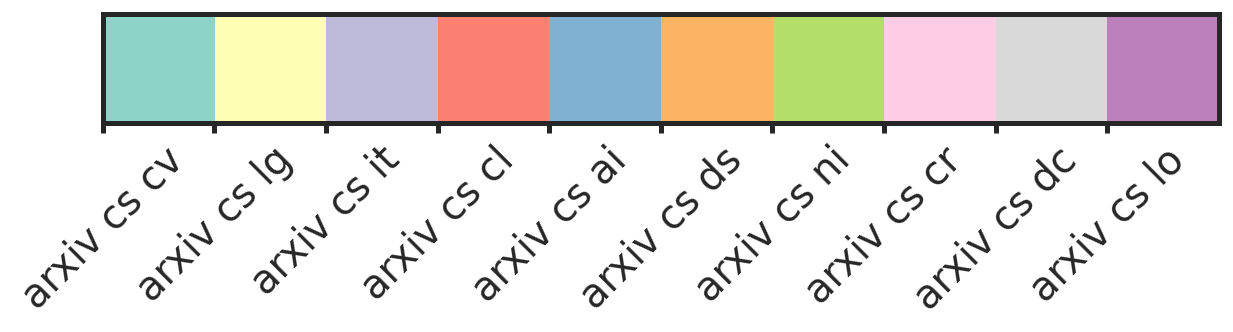

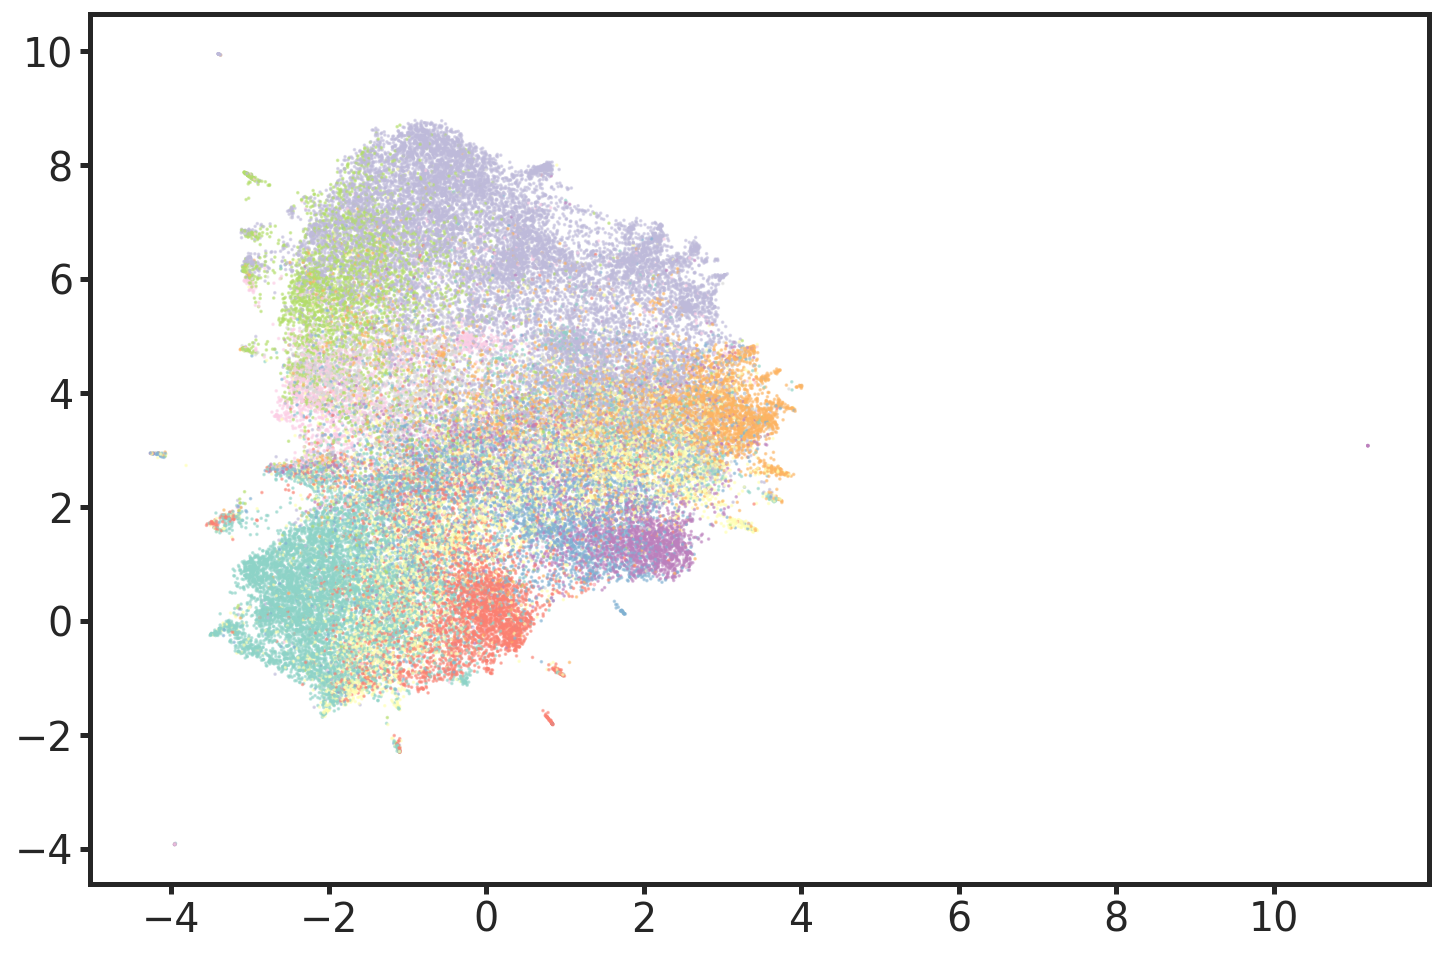

In [157]:
plot_color_legend()
plt.scatter(node_umap[:,0], node_umap[:, 1],
            c=labels_to_nodecolors(y_train),
            s=1, alpha=0.5)
plt.show()

## Interactivo

In [188]:
indices = np.random.permutation(len(node_umap))[:5000]

vis_df = pd.DataFrame()
vis_df['UMAP1'] = node_umap[indices, 0]
vis_df['UMAP2'] = node_umap[indices, 1]
vis_df['label'] = y_train[indices].ravel()
vis_df['id'] = paperids_train[indices]
vis_df['title'] = paper_df.loc[vis_df['id']]['title'].tolist()
vis_df

,UMAP1,UMAP2,label,id,title
0,-0.489689,6.631971,6,2084007617,to relay or not to relay in cognitive radio se...
1,-0.570316,0.923403,3,2952808631,a new data representation based on training da...
2,-1.305045,1.807612,0,2777739488,automated surgical skill assessment in rmis tr...
3,-2.539529,2.457403,0,2950517871,what uncertainties do we need in bayesian deep...
4,-1.650121,8.046225,6,1485485591,context based cell search in millimeter wave 5...
...,...,...,...,...,...
4995,-0.765474,4.269414,5,2952211204,dynamic ftss in asynchronous systems the case ...
4996,-2.093948,2.468349,1,155338088,where do goals come from a generic approach to...
4997,1.871816,4.639778,2,2594298325,strong chain rules for min entropy under few b...
4998,-0.265344,2.788132,4,2951255015,spatial aggregation theory and applications


In [190]:
alt.Chart(vis_df).mark_circle(size=10).encode(
    x='UMAP1:Q',
    y='UMAP2:Q',
    color='label:N',
    tooltip=['id', 'label', 'title']
).interactive()

alt.Chart(...)

## Vamos a crear mini-batches de grafos

Para una version mas avanzada checa: https://arxiv.org/abs/2006.04311

In [210]:
def get_batch(x, y, center_node, radius=3, batch_size=128):
    """Sub-samplea el graph."""
    nx_graph = gn.utils_np.graphs_tuple_to_networkxs(x)[0].to_undirected()
    sub_graph = nx.generators.ego_graph(nx_graph.to_undirected(),
                                        n=center_node, radius=radius)
    node_indices = list(sub_graph.nodes)[:batch_size]
    g_batch = sub_graph.subgraph(node_indices)
    g_batch = nx.relabel.convert_node_labels_to_integers(g_batch)
    y_batch = y[node_indices].ravel()
    return g_batch, y_batch

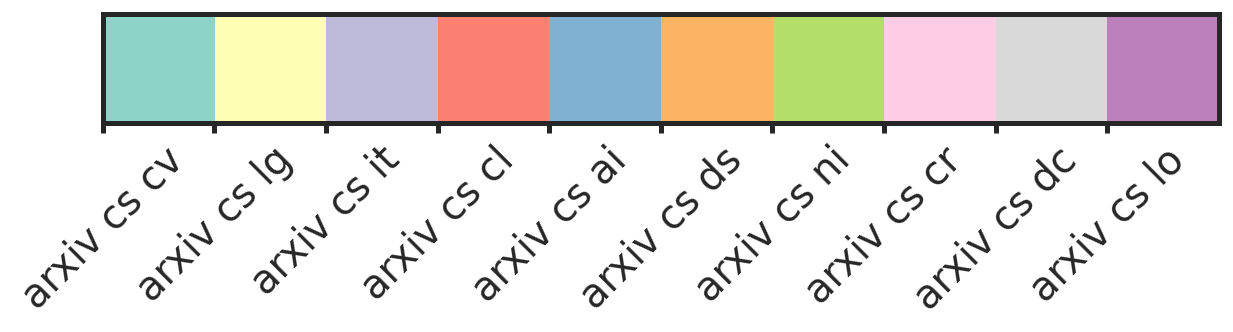

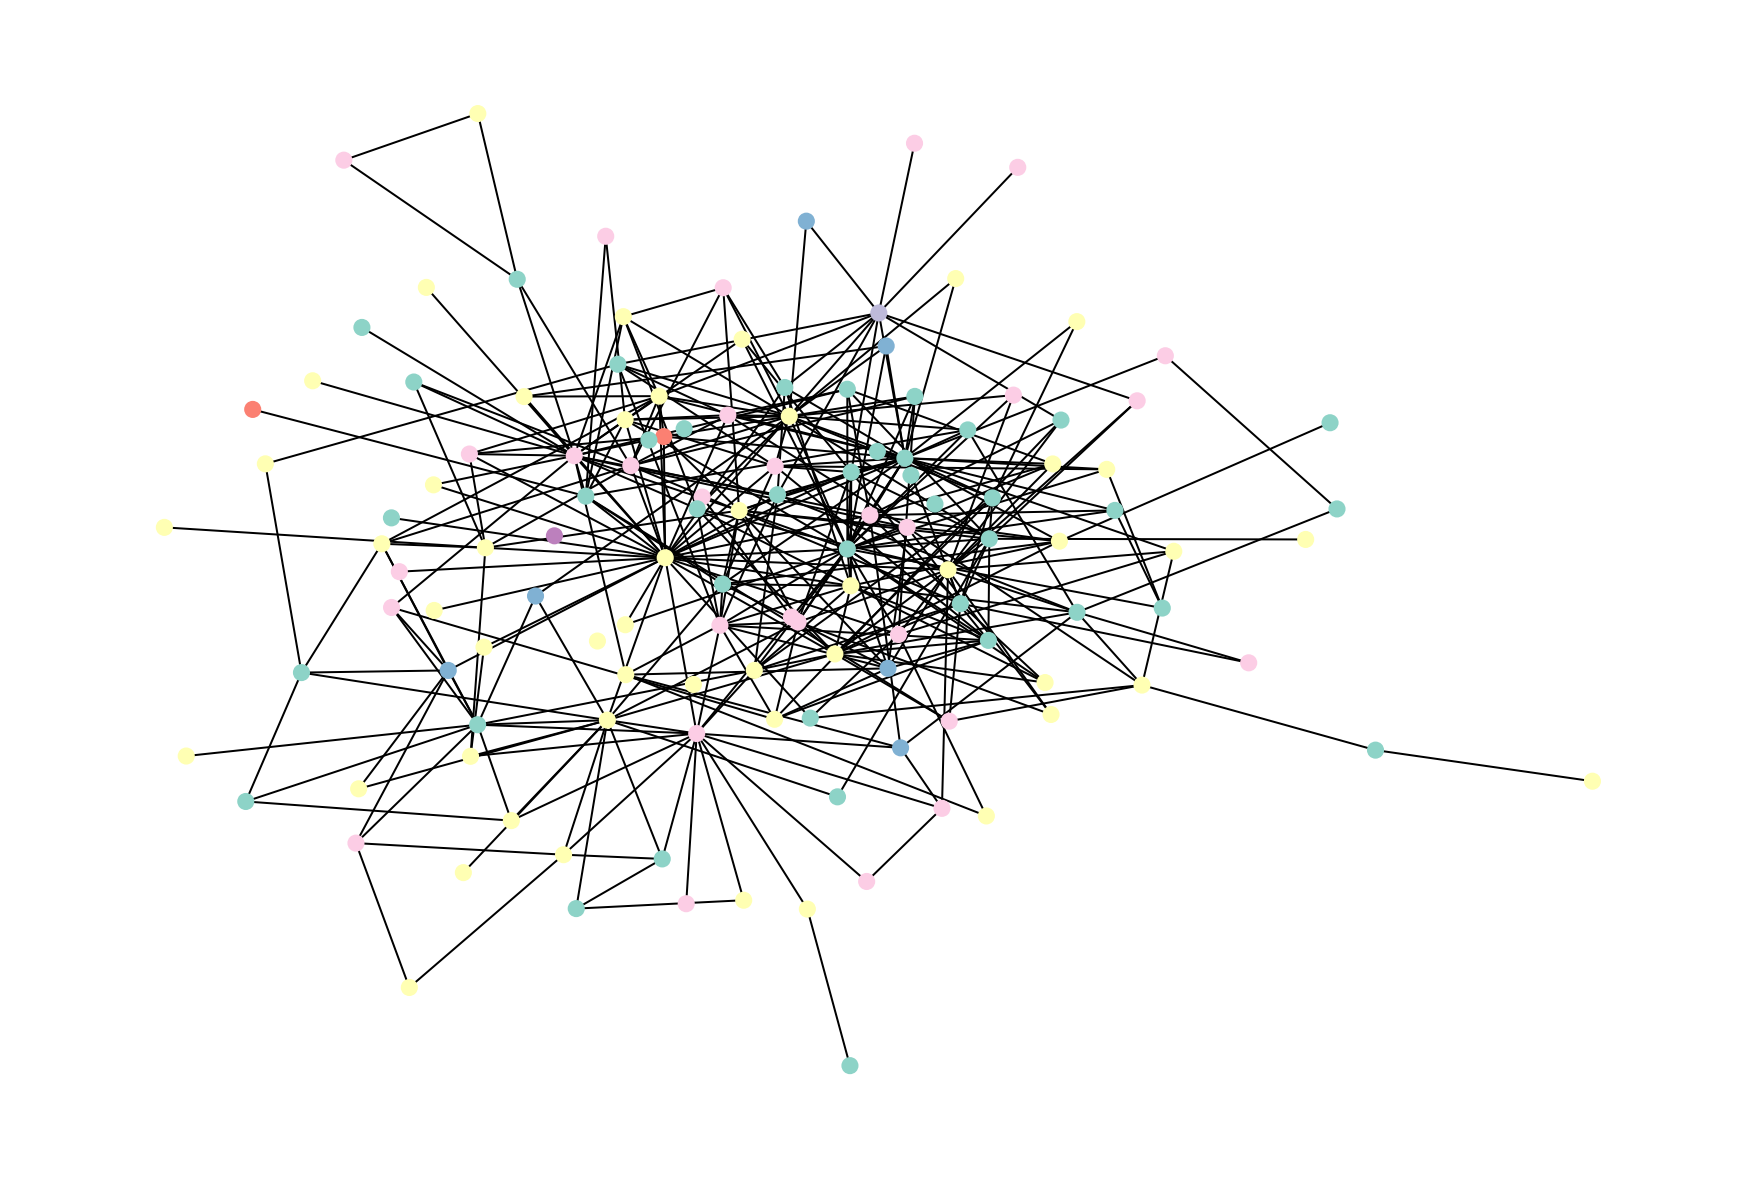

In [211]:
g_batch, y_batch = get_batch(x_train, y_train, center_node=0, radius=2)
plot_color_legend()
pos = nx.kamada_kawai_layout(g_batch)
nx.draw(g_batch, pos, node_size=60, node_color=labels_to_nodecolors(y_batch))

In [213]:
x_batch = nx_to_graph_stuple(g_batch)
x_batch

GraphsTuple(nodes=<tf.Tensor: shape=(128, 128), dtype=float32, numpy=
array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
        -0.140059],
       [-0.292602,  0.039839, -0.110666, ...,  0.055168,  0.006917,
        -0.19729 ],
       [-0.170794, -0.106782,  0.024896, ..., -0.034245, -0.260145,
        -0.340165],
       ...,
       [-0.026416, -0.070936, -0.015691, ...,  0.036734, -0.04733 ,
        -0.036821],
       [-0.18894 , -0.017244,  0.033169, ..., -0.016991,  0.031816,
        -0.193636],
       [-0.198762, -0.038401, -0.041066, ...,  0.11904 ,  0.040412,
        -0.215465]], dtype=float32)>, edges=<tf.Tensor: shape=(358, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
    

# Nuestro primer GNN

In [117]:
def get_num_parameters(model: snt.Module, trainable: bool = True) -> int:
  """Numero de parametros."""
  variables = model.trainable_variables if trainable else model.variables
  return int(np.sum([np.prod(v.shape) for v in variables]))


def print_model(model: snt.Module):
  """Sumario de un modelo."""
  print(f'{model.__class__.__name__} : {model.name}\n')
  print(snt.format_variables(model.variables))
  n_params = get_num_parameters(model, False)
  trainable_params = get_num_parameters(model, True)
  print(f'\nParams: {trainable_params} trainable out of {n_params}')

## Bloque de transformacion

In [118]:
def make_mlp_model(latent_size=32, n_layers=2, add_head=0):
    """Crea un MLP luego pasando por un LayerNorm y opcionalmente una capa lineal."""
    layers = [
        snt.nets.MLP([latent_size] * n_layers, activate_final=True),
        snt.LayerNorm(axis=-1, create_offset=True, create_scale=True)]
    if add_head > 0:
        layers.append(snt.Linear(add_head))
    return snt.Sequential(layers)
    
bloque = make_mlp_model(32, 2, 0)
bloque(x_batch.nodes)
print_model(bloque)

Sequential : sequential

| Variable          | Spec        | Trainable   | Device   |
|-------------------+-------------+-------------+----------|
| layer_norm/offset | f32[32]     | True        | GPU      |
| layer_norm/scale  | f32[32]     | True        | GPU      |
| mlp/linear_0/w    | f32[128,32] | True        | GPU      |
| mlp/linear_0/b    | f32[32]     | True        | GPU      |
| mlp/linear_1/w    | f32[32,32]  | True        | GPU      |
| mlp/linear_1/b    | f32[32]     | True        | GPU      |

Params: 5248 trainable out of 5248


# Un GNN independiente

In [130]:
gnn = gn.modules.GraphIndependent(node_model_fn=lambda: make_mlp_model(32, 2, N_LABELS))
x_batch = nx_to_graph_stuple(g_batch)
out = gnn(x_batch)
print_model(gnn)

GraphIndependent : graph_independent

| Variable                                       | Spec        | Trainable   | Device   |
|------------------------------------------------+-------------+-------------+----------|
| graph_independent/node_model/layer_norm/offset | f32[32]     | True        | GPU      |
| graph_independent/node_model/layer_norm/scale  | f32[32]     | True        | GPU      |
| graph_independent/node_model/linear/w          | f32[32,10]  | True        | GPU      |
| graph_independent/node_model/linear/b          | f32[10]     | True        | GPU      |
| graph_independent/node_model/mlp/linear_0/w    | f32[128,32] | True        | GPU      |
| graph_independent/node_model/mlp/linear_0/b    | f32[32]     | True        | GPU      |
| graph_independent/node_model/mlp/linear_1/w    | f32[32,32]  | True        | GPU      |
| graph_independent/node_model/mlp/linear_1/b    | f32[32]     | True        | GPU      |

Params: 5578 trainable out of 5578


# A Entrenar !

In [131]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [132]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.nodes

def logits_to_stats(y_true, node_logits):
    """Convert predicted logits to class stats."""
    loss = loss_fn(y_true, node_logits)
    probs = tf.nn.softmax(node_logits)
    acc = metric(y_true, probs).numpy()
    return loss.numpy(), acc

In [133]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = defaultdict(list)

for i in pbar:
    with tf.GradientTape() as tape:
      node_logits = forward_pass(x_train)
      loss = loss_fn(y_train, node_logits)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients(zip(grads, gnn.trainable_variables))
    # Train statistics.
    train_loss, train_acc = logits_to_stats(y_train, node_logits)
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    # Validation statistics.
    node_logits = forward_pass(x_valid)
    valid_loss, valid_acc = logits_to_stats(y_valid, node_logits)
    stats['valid_loss'].append(valid_loss)
    stats['valid_acc'].append(valid_acc)
    # Update progress bar.
    pbar.set_postfix({key:values[-1] for key, values in stats.items()})
    

  0%|          | 0/100 [00:00<?, ?it/s]

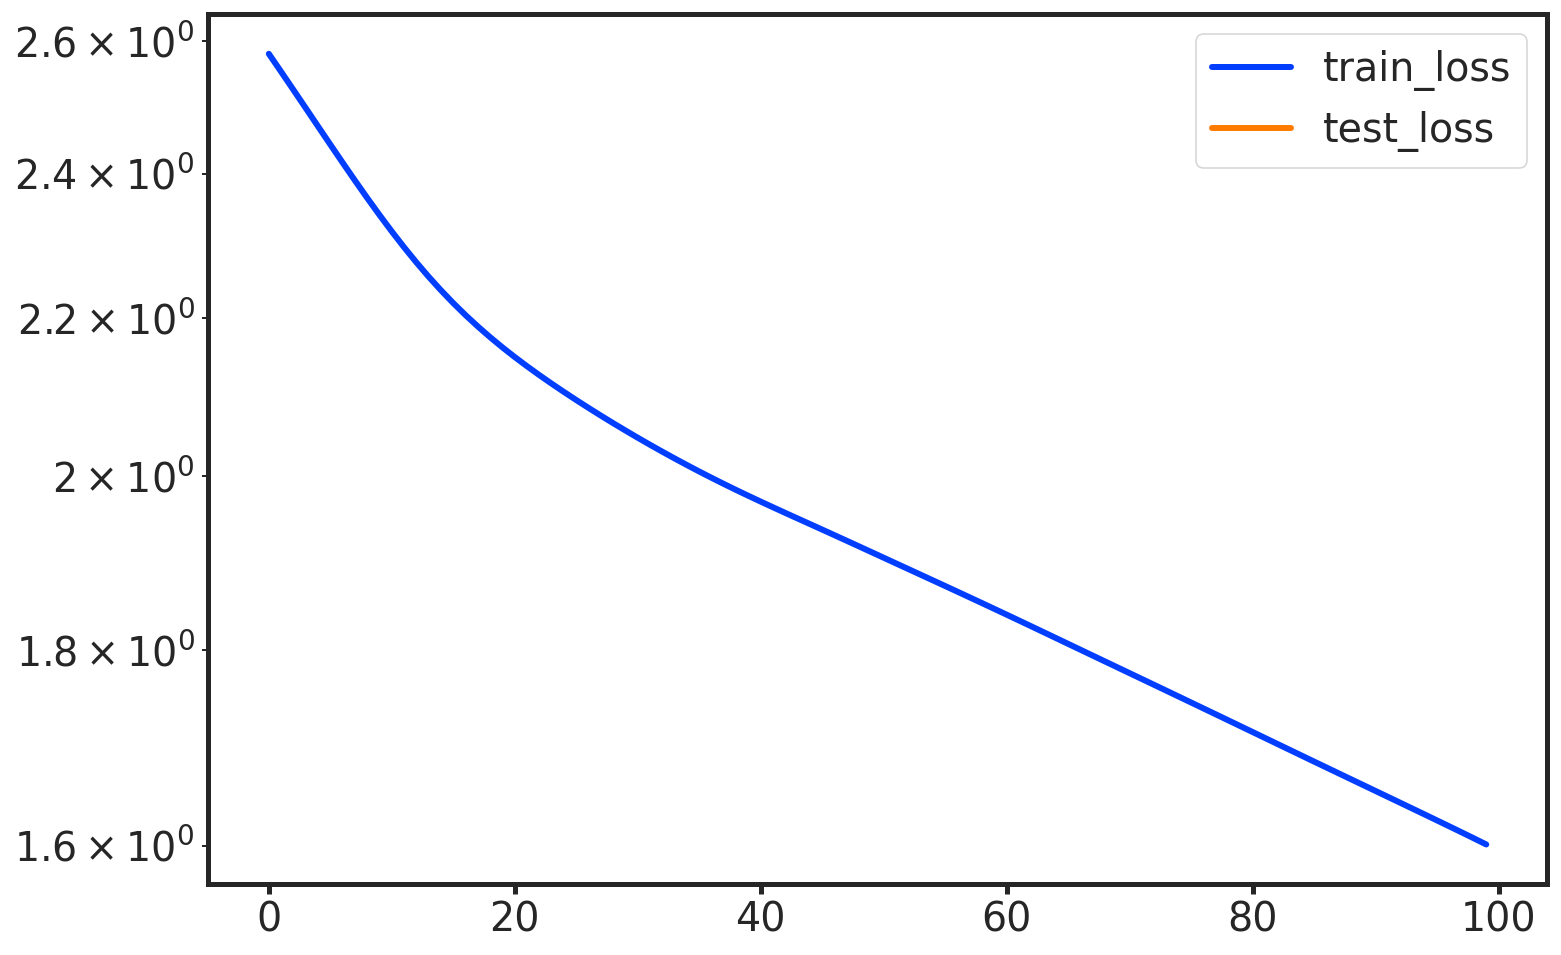

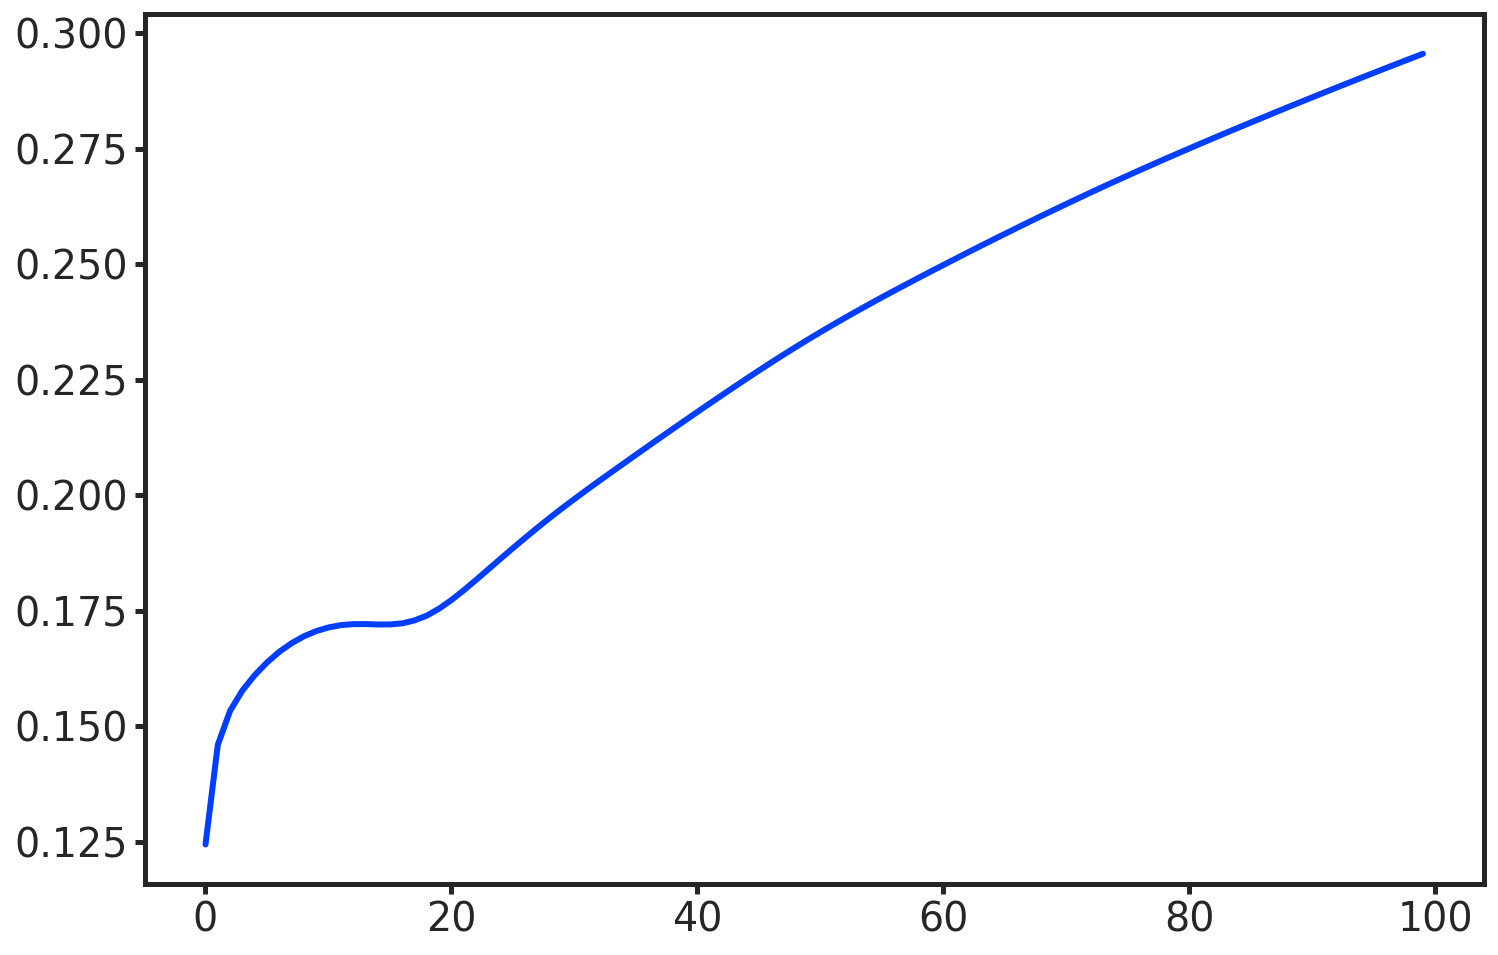

In [134]:
for key in ['train_loss','test_loss']:
    plt.plot(stats[key],label=key)
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_acc','test_acc']:
    plt.plot(stats[key],label=key)
plt.show()

## GNN: GraphNets

In [ ]:
cabeza = gn.modules.GraphIndependent(
    node_model_fn=lambda: make_mlp_model(32, 2, N_LABELS))

gnn_layers = [gn.modules.GraphNetwork(
    edge_model_fn=lambda: make_mlp_model(32, 2),
    node_model_fn=lambda: make_mlp_model(32, 2),
    global_model_fn=lambda: make_mlp_model(32, 2)) for i in range(3)]

gnn = snt.Sequential( gnn_layers + [cabeza])
x_batch = nx_to_graph_stuple(g_batch)
out = gnn(x_batch)
print_model(gnn)

Sequential : sequential

| Variable                                       | Spec        | Trainable   | Device   |
|------------------------------------------------+-------------+-------------+----------|
| graph_independent/node_model/layer_norm/offset | f32[32]     | True        | CPU      |
| graph_independent/node_model/layer_norm/scale  | f32[32]     | True        | CPU      |
| graph_independent/node_model/linear/w          | f32[32,10]  | True        | CPU      |
| graph_independent/node_model/linear/b          | f32[10]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/w    | f32[32,32]  | True        | CPU      |
| graph_independent/node_model/mlp/linear_0/b    | f32[32]     | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/w    | f32[32,32]  | True        | CPU      |
| graph_independent/node_model/mlp/linear_1/b    | f32[32]     | True        | CPU      |
| graph_network/edge_block/layer_norm/offset     | f32[32]     | True      

In [135]:
NUM_ITER = 100
optimizer = tf.optimizers.Adam(3e-4)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [136]:
@tf.function(experimental_relax_shapes=True)
def forward_pass(x):
    """Prediccion."""
    out_x = gnn(x)
    return out_x.nodes

def logits_to_stats(y_true, node_logits):
    """Convert predicted logits to class stats."""
    loss = loss_fn(y_true, node_logits)
    probs = tf.nn.softmax(node_logits)
    acc = metric(y_true, probs).numpy()
    return loss.numpy(), acc

In [137]:
pbar = tqdm.tqdm(range(NUM_ITER))
stats = defaultdict(list)

for i in pbar:
    with tf.GradientTape() as tape:
      node_logits = forward_pass(x_train)
      loss = loss_fn(y_train, node_logits)
    grads = tape.gradient(loss, gnn.trainable_variables)
    optimizer.apply_gradients((grad, var) 
    for (grad, var) in zip(grads, gnn.trainable_variables) 
    if grad is not None)
    # Train statistics.
    train_loss, train_acc = logits_to_stats(y_train, node_logits)
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    # Validation statistics.
    node_logits = forward_pass(x_valid)
    valid_loss, valid_acc = logits_to_stats(y_valid, node_logits)
    stats['valid_loss'].append(valid_loss)
    stats['valid_acc'].append(valid_acc)
    # Update progress bar.
    pbar.set_postfix({key:values[-1] for key, values in stats.items()})

  0%|          | 0/100 [00:00<?, ?it/s]

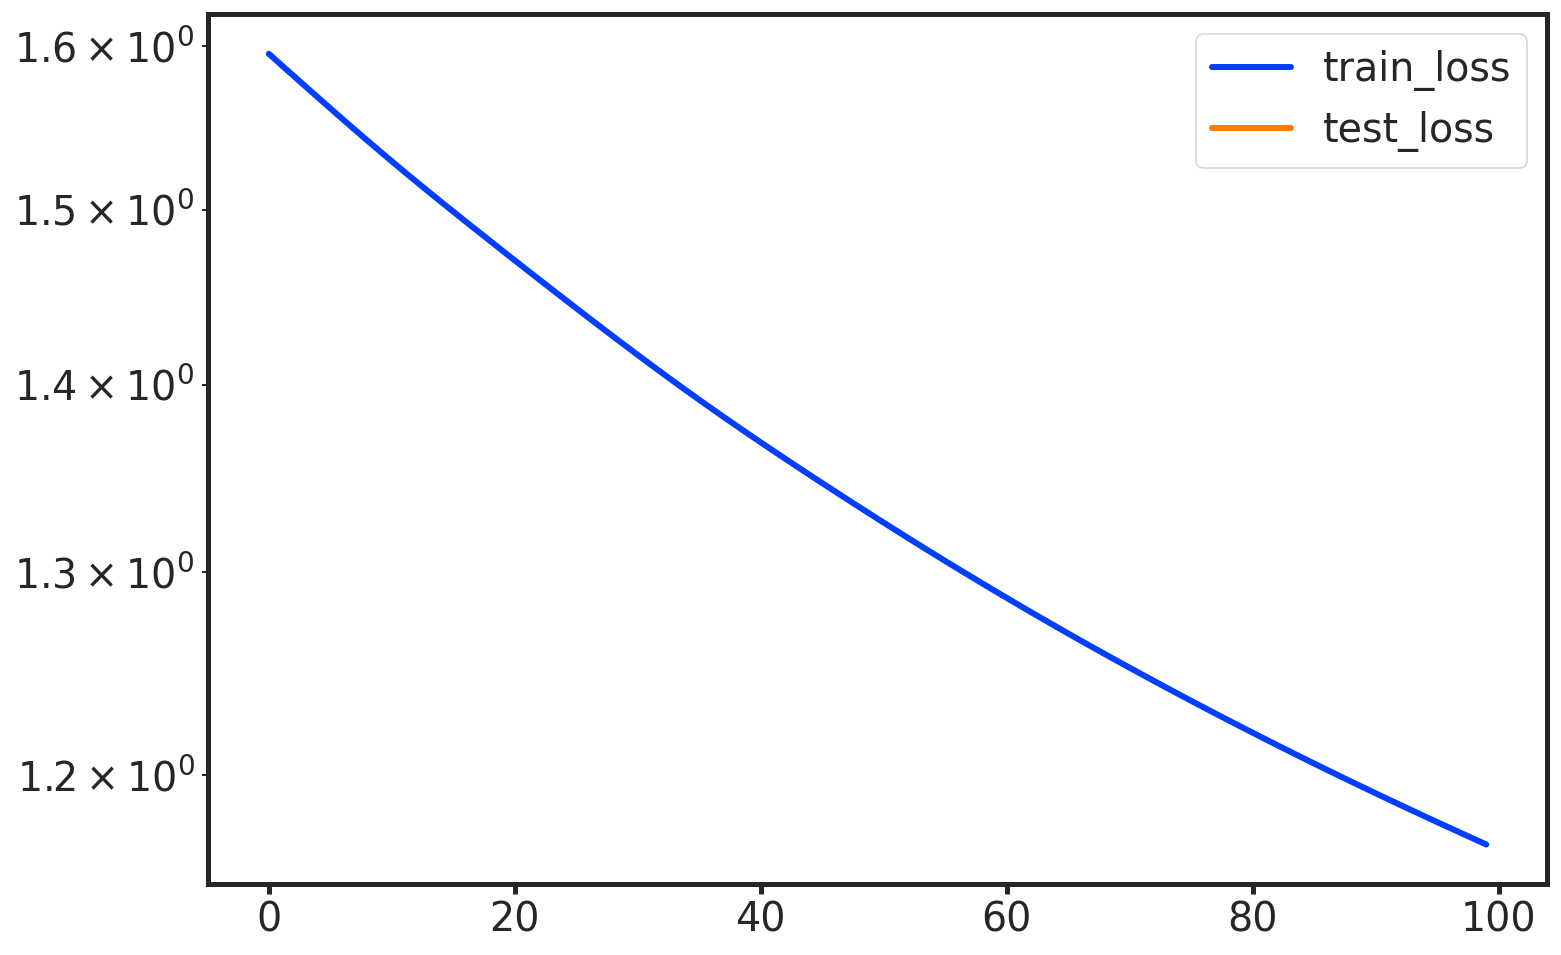

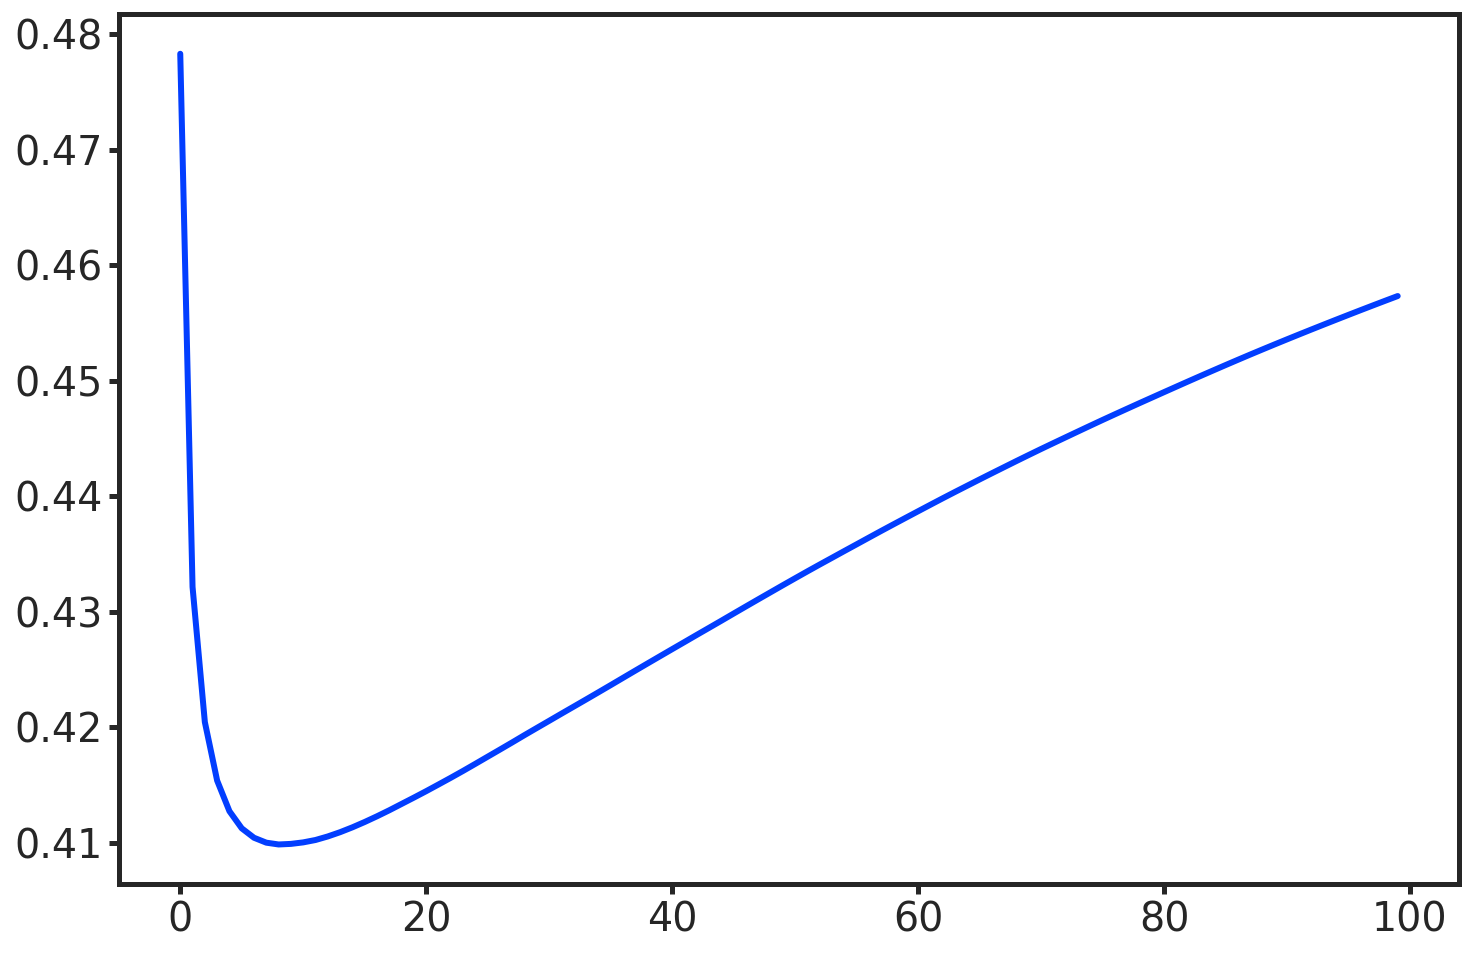

In [138]:
for key in ['train_loss','test_loss']:
    plt.plot(stats[key],label=key)
plt.yscale('log')
plt.legend()
plt.show()

for key in ['train_acc','test_acc']:
    plt.plot(stats[key],label=key)
plt.show()